In [4]:
%matplotlib inline

import pandas as pd
import quandl

In [5]:
df = pd.read_csv("nse_50.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-03-21,6515.200195,6522.899902,6485.700195,6493.200195,6493.200195,189900.0
1,2014-03-22,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-03-24,6510.500000,6591.500000,6510.500000,6583.500000,6583.500000,158400.0
3,2014-03-25,6550.100098,6595.549805,6544.850098,6589.750000,6589.750000,168100.0
4,2014-03-26,6615.649902,6627.450195,6580.600098,6601.399902,6601.399902,186600.0


In [6]:
df = df[df["Date"]>"2018-03-01"]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


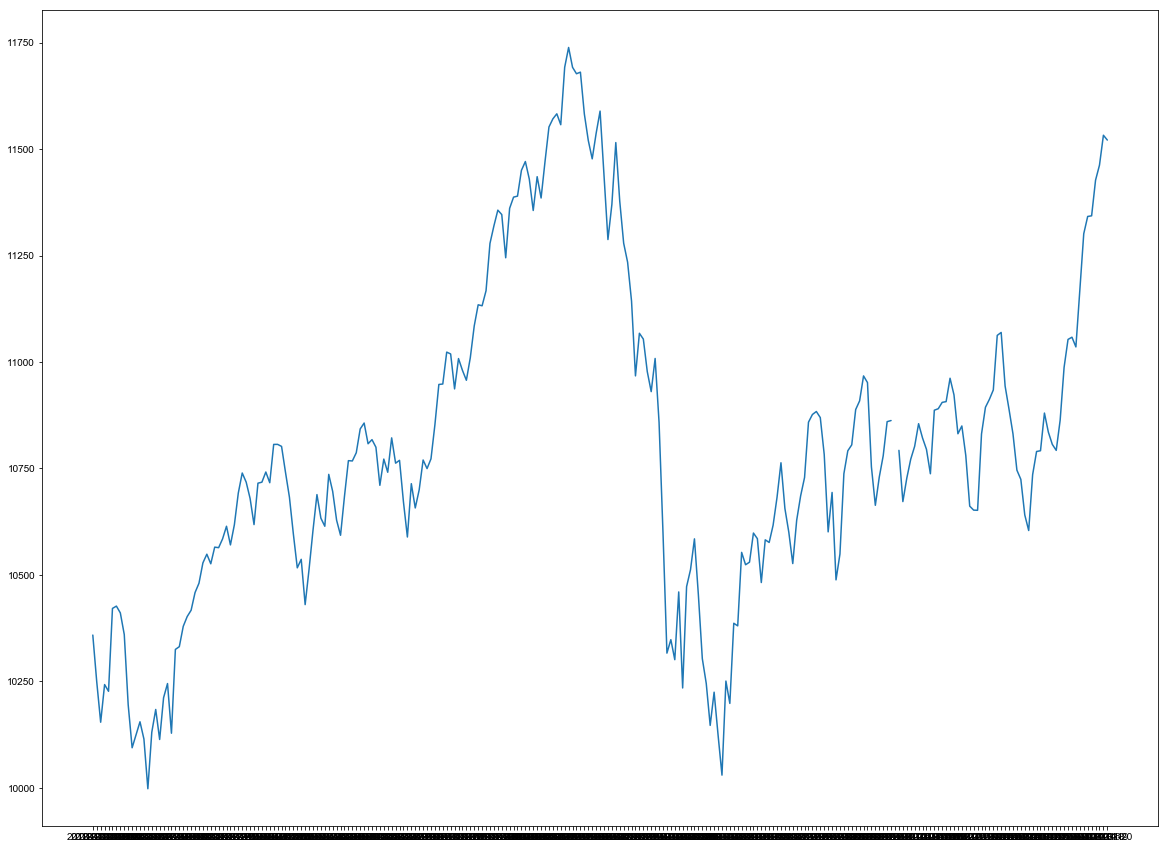

In [8]:
f,ax = plt.subplots(1,figsize=(20,15))

x = df["Date"]
y = df["Adj Close"]
sns.set()
ax = plt.plot(x,y)

f.show()

In [10]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
from talib import RSI, BBANDS, MACD
import matplotlib.pyplot as plt
start = '2015-04-22'
end = '2017-04-22'

symbol = 'TCS'
max_holding = 100
price = web.DataReader(name=symbol, data_source='quandl', start=start, end=end,  access_key="B2LcBEywuebxqE9s15L9")
price = price.iloc[::-1]
price = price.dropna()
close = price['AdjClose'].values
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
rsi = RSI(close, timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [15.30740276 18.81765196 17.61379154 32.12084802 31.37708919 30.53549926
 30.72606863 32.12969876 33.57904663 33.79654707]


In [11]:
def bbp(price):
    up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    bbp = (price['AdjClose'] - low) / (up - low)
    return bbp

In [12]:
price['RSI']=rsi
price['BBP']=bbp(price)

holdings = pd.DataFrame(index=price.index, data={'Holdings': np.array([np.nan] * price.index.shape[0])})
holdings.loc[((price['RSI'] < 30) & (price['BBP'] < 0)), 'Holdings'] = max_holding
holdings.loc[((price['RSI'] > 70) & (price['BBP'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

In [13]:
macd, macdsignal, macdhist = MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

In [14]:
holdings['Order'] = holdings.diff()
holdings.dropna(inplace=True)

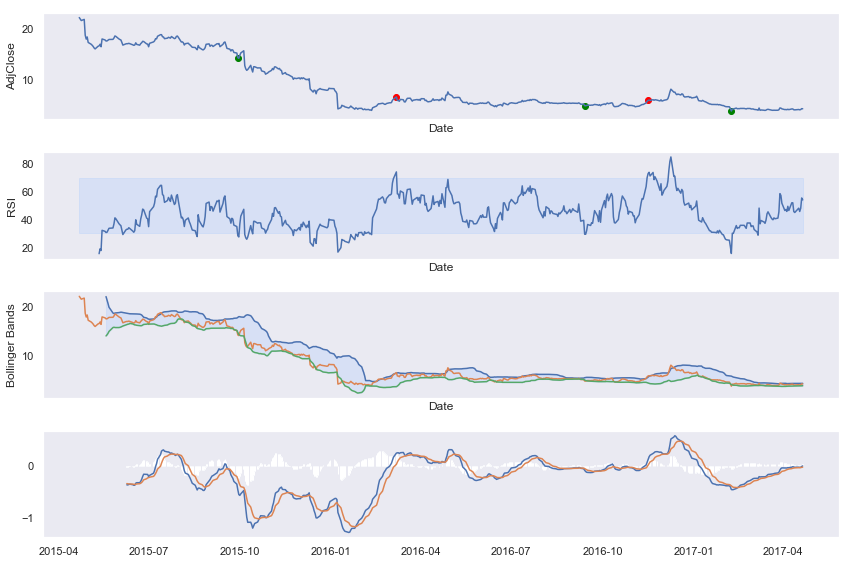

In [15]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(12, 8))
ax0.plot(price.index, price['AdjClose'], label='AdjClose')
ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid()

for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=price.loc[day, 'AdjClose'], color='red')

ax1.plot(price.index, price['RSI'], label='RSI')
ax1.fill_between(price.index, y1=30, y2=70, color='#adccff', alpha='0.3')
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

price['BB_up'] = up
price['BB_low'] = low

ax2.plot(price.index, price['BB_up'], label='BB_up')
ax2.plot(price.index, price['AdjClose'], label='AdjClose')
ax2.plot(price.index, price['BB_low'], label='BB_low')
ax2.fill_between(price.index, y1=price['BB_low'], y2=price['BB_up'], color='#adccff', alpha='0.3')
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()


ax3.plot(price.index, macd, label='MACD')
ax3.bar(price.index, macdhist, label='MACD Hist')
ax3.plot(price.index, macdsignal, label='MACD signal')
ax3.grid()

fig.tight_layout()
plt.show()